# Building your own algorithm container

With Amazon SageMaker, you can package your own algorithms that can than be deployed in the SageMaker hosting environment. This notebook will guide you through an example that shows you how to build a fast.ai Docker container for SageMaker and use it for inference.

By packaging an algorithm in a container, you can bring almost any code to the Amazon SageMaker environment, regardless of programming language, environment, framework, or dependencies. 

## Download the fast.ai trained model

The first thing we need to do is download the trained fast.ai model from a publicaly accessible S3 bucket. We will copy this file to our own S3 bucket so that we can create a SageMaker model from it.

In [9]:
import boto3
from sagemaker import get_execution_role

role = get_execution_role()
print(f'Role is: {role}')

region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity().get('Account')

bucket = 'sagemaker-{}-{}'.format(account_id, region)
print(f'Bucket is: {bucket}')

Role is: arn:aws:iam::934676248949:role/AmsterdamMLWorkshop-SageMakerIamRole-1EK3SH7FNF0IR
Bucket is: sagemaker-934676248949-eu-west-1


In [2]:
import os
import urllib.request

def download(url):
    filename = url.split("/")[-1]
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)


# # Download the trained fast.ai model
download('https://s3-eu-west-1.amazonaws.com/mmcclean-public-files/fastai_caltech256_model.tar.gz')
upload_to_s3('models', 'fastai_caltech256_model.tar.gz')

## Running your container during hosting

Hosting has a very different model than training because hosting is reponding to inference requests that come in via HTTP. In this example, we use our recommended Python serving stack to provide robust and scalable serving of inference requests:

![Request serving stack](stack.png)

This stack is implemented in the sample code here and you can mostly just leave it alone. 

Amazon SageMaker uses two URLs in the container:

* `/ping` will receive `GET` requests from the infrastructure. Your program returns 200 if the container is up and accepting requests.
* `/invocations` is the endpoint that receives client inference `POST` requests. The format of the request and the response is up to the algorithm. If the client supplied `ContentType` and `Accept` headers, these will be passed in as well. 

The container will have the model files in the same place they were written during training:

    /opt/ml
    └── model
        └── <model files>


### The parts of the sample container

In the `container` directory are all the components you need to package the sample algorithm for Amazon SageMager:

    .
    ├── Dockerfile
    ├── build_and_push.sh
    └── fastai_caltech256
        ├── model.py
        ├── nginx.conf
        ├── predict.py        
        ├── predictor.py
        ├── serve
        ├── utils.py
        └── wsgi.py

Let's discuss each of these in turn:

* __`Dockerfile`__ describes how to build your Docker container image. More details below.
* __`build_and_push.sh`__ is a script that uses the Dockerfile to build your container images and then pushes it to ECR. We'll invoke the commands directly later in this notebook, but you can just copy and run the script for your own algorithms.
* __`fastai_caltech256`__ is the directory which contains the files that will be installed in the container.
* __`local_test`__ is a directory that shows how to test your new container on any computer that can run Docker, including an Amazon SageMaker notebook instance. Using this method, you can quickly iterate using small datasets to eliminate any structural bugs before you use the container with Amazon SageMaker. We'll walk through local testing later in this notebook.

In this simple application, we only install seven files in the container. You may only need that many or, if you have many supporting routines, you may wish to install more. These five show the standard structure of our Python containers, although you are free to choose a different toolset and therefore could have a different layout. If you're writing in a different programming language, you'll certainly have a different layout depending on the frameworks and tools you choose.

The files that we'll put in the container are:

* __`model.py`__ is the singleton class that loads the fast.ai model and classes objects from the model directory.
* __`nginx.conf`__ is the configuration file for the nginx front-end. Generally, you should be able to take this file as-is.
* __`predict.py`__ is the main class with the logic to do the fast.ai predictions. You'll want to customize the actual prediction parts to your application.
* __`predictor.py`__ is the program that actually implements the Flask web server. You'll want to customize the actual prediction parts to your application.
* __`serve`__ is the program started when the container is started for hosting. It simply launches the gunicorn server which runs multiple instances of the Flask app defined in `predictor.py`. You should be able to take this file as-is.
* __`utils.py`__ is a utility file with functions to do things such as transform the image before sending to the model for inference. It implements many of the fast.ai image transformation functions.
* __`wsgi.py`__ is a small wrapper used to invoke the Flask app. You should be able to take this file as-is.

In summary, the file you will probably want to change for your application is `predictor.py`.

## The Dockerfile

The Dockerfile describes the image that we want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations. 

For the Python science stack, we will start from a standard Python installation and run the normal tools to install the things needed by fast.ai library. Finally, we add the code that implements our specific algorithm to the container and set up the right environment to run under.

Along the way, we clean up extra space. This makes the container smaller and faster to start.

Let's look at the Dockerfile for the example:

In [3]:
!cat container/Dockerfile

# Build an image that can do training and inference in SageMaker
# This is an image that uses the nginx, gunicorn, flask stack
# for serving inferences in a stable way.

FROM python:3.6.5-slim-stretch

MAINTAINER Amazon AI <mmcclean@amazon.com>


RUN apt-get -y update && apt-get install -y --no-install-recommends \
         nginx \
         ca-certificates \
         libglib2.0-dev \
    && rm -rf /var/lib/apt/lists/*


# Here we get all python packages.
RUN pip install flask gevent gunicorn future
RUN pip install boto3 pyyaml dill numpy opencv-python-headless \
    http://download.pytorch.org/whl/cpu/torch-0.3.1-cp36-cp36m-linux_x86_64.whl \
    https://s3-eu-west-1.amazonaws.com/mmcclean-public-files/fastai-lib.zip && \ 
    rm -rf /root/.cache

# Set some environment variables. PYTHONUNBUFFERED keeps Python from buffering our standard
# output stream, which means that logs can be delivered to the user quickly. PYTHONDONTWRITEBYTECODE
# keeps Python from writing the .pyc files which 

## Building and registering the container

The following shell code shows how to build the container image using `docker build` and push the container image to ECR using `docker push`. This code is also available as the shell script `container/build-and-push.sh`, which you can run as `build-and-push.sh fastai_predict` to build the image `fastai_predict`. 

This code looks for an ECR repository in the account you're using and the current default region (if you're using a SageMaker notebook instance, this will be the region where the notebook instance was created). If the repository doesn't exist, the script will create it.

In [4]:
! cd container && ./build_and_push.sh fastai_predict

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
Login Succeeded
Sending build context to Docker daemon  41.98kB
Step 1/10 : FROM python:3.6.5-slim-stretch
 ---> 29ea9c0b39c6
Step 2/10 : MAINTAINER Amazon AI <mmcclean@amazon.com>
 ---> Using cache
 ---> 82f144559570
Step 3/10 : RUN apt-get -y update && apt-get install -y --no-install-recommends          nginx          ca-certificates          libglib2.0-dev     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> a57235fe4be9
Step 4/10 : RUN pip install flask gevent gunicorn future
 ---> Using cache
 ---> 2007ca277d5f
Step 5/10 : RUN pip install boto3 pyyaml dill numpy opencv-python-headless     http://download.pytorch.org/whl/cpu/torch-0.3.1-cp36-cp36m-linux_x86_64.whl     https://s3-eu-west-1.amazonaws.com/mmcclean-public-files/fastai-lib.zip &&     rm -rf /root/.cache
 ---> Using cache
 ---> 756bc58e63ae
Step 6/10 : ENV PYTHONUNBUFFERED=TRUE
 ---> Using cache
 ---> e69902e2009f
Step 7/10 : ENV PYTHONDONTWRI

## Host

Stary by defining our model to hosting.  Amazon SageMaker Algorithm containers are published to accounts which are unique across region, so we've accounted for that here.

In [12]:
import time


fastai_model = 'DEMO-fastai-byom-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

sm = boto3.client('sagemaker')

image = '{}.dkr.ecr.{}.amazonaws.com/fastai_predict:latest'.format(account_id, region)

create_model_response = sm.create_model(
    ModelName=fastai_model,
    ExecutionRoleArn=role,
    PrimaryContainer={
        'Image': image,
        'ModelDataUrl': 's3://{}/models/fastai_caltech256_model.tar.gz'.format(bucket)})

model_arn=create_model_response['ModelArn']

print(f'Model Arn: {model_arn}')

Model ARN:arn:aws:sagemaker:eu-west-1:934676248949:model/demo-fastai-byom-2018-06-05-16-58-34


Then setup our endpoint configuration.

In [13]:
fastai_endpoint_config = 'DEMO-fastai-byom-endpoint-config-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(fastai_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=fastai_endpoint_config,
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': fastai_model,
        'VariantName': 'AllTraffic'}])

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

DEMO-fastai-byom-endpoint-config-2018-06-05-16-58-49
Endpoint Config Arn: arn:aws:sagemaker:eu-west-1:934676248949:endpoint-config/demo-fastai-byom-endpoint-config-2018-06-05-16-58-49


Finally, initiate our endpoints.

In [14]:
%%time

fastai_endpoint = 'DEMO-fastai-byom-endpoint-' + time.strftime("%Y%m%d%H%M", time.gmtime())
print(fastai_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=fastai_endpoint,
    EndpointConfigName=fastai_endpoint_config)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=fastai_endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

sm.get_waiter('endpoint_in_service').wait(EndpointName=fastai_endpoint)

resp = sm.describe_endpoint(EndpointName=fastai_endpoint)
status = resp['EndpointStatus']
print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

if status != 'InService':
    raise Exception('Endpoint creation did not succeed')

DEMO-fastai-byom-endpoint-201806051659
arn:aws:sagemaker:eu-west-1:934676248949:endpoint/demo-fastai-byom-endpoint-201806051659
Status: Creating
Arn: arn:aws:sagemaker:eu-west-1:934676248949:endpoint/demo-fastai-byom-endpoint-201806051659
Status: InService
CPU times: user 44 ms, sys: 8 ms, total: 52 ms
Wall time: 5min 31s


## Perform Inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.

In [15]:
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 

### Download test image

--2018-06-05 17:05:24--  http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
Resolving www.vision.caltech.edu (www.vision.caltech.edu)... 34.208.54.77
Connecting to www.vision.caltech.edu (www.vision.caltech.edu)|34.208.54.77|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23750 (23K) [image/jpeg]
Saving to: ‘/tmp/test.jpg’

/tmp/test.jpg       100%[===================>]  23.19K  --.-KB/s    in 0.1s    

2018-06-05 17:05:26 (167 KB/s) - ‘/tmp/test.jpg’ saved [23750/23750]



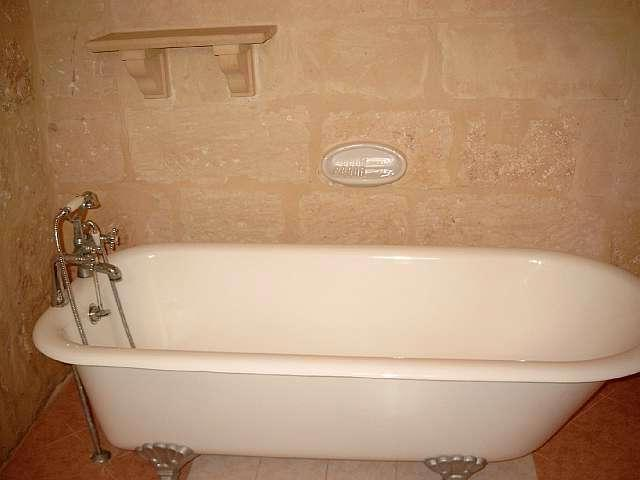

In [16]:
!wget -O /tmp/test.jpg http://www.vision.caltech.edu/Image_Datasets/Caltech256/images/008.bathtub/008_0007.jpg
file_name = '/tmp/test.jpg'
# test image
from IPython.display import Image
Image(file_name)  

In [19]:
import json
import numpy as np
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=fastai_endpoint, 
                                   ContentType='image/jpeg', 
                                   Body=payload)
result = response['Body'].read()
res = json.loads(result)
res

{'class': '008.bathtub', 'confidence': 1.0}

### Clean up

When we're done with the endpoint, we can just delete it and the backing instances will be released.  Run the following cell to delete the endpoint.

In [20]:
sm.delete_endpoint(EndpointName=fastai_endpoint)

{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
   'content-length': '0',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 05 Jun 2018 17:06:38 GMT',
   'x-amzn-requestid': 'a0aa5fbe-8ad7-41b8-a526-d8c17244f26c'},
  'HTTPStatusCode': 200,
  'RequestId': 'a0aa5fbe-8ad7-41b8-a526-d8c17244f26c',
  'RetryAttempts': 0}}